In [109]:
from virtual_swap.deprecated.vswap_pass import VirtualSwap
from qiskit import QuantumCircuit

# from qiskit.test import QiskitTestCase
from qiskit.transpiler import CouplingMap, PassManager
from qiskit.transpiler.passes import (
    Unroller,
    TrivialLayout,
    DenseLayout,
    ApplyLayout,
    SabreLayout,
    CountOpsLongestPath,
    Collect1qRuns,
    Collect2qBlocks,
    ConsolidateBlocks,
    SabreSwap,
)
from qiskit.transpiler.passes import OptimizeSwapBeforeMeasure
import numpy as np

from qiskit.transpiler.passes import (
    FullAncillaAllocation,
    EnlargeWithAncilla,
)
from virtual_swap.sqiswap_equiv import sel

from qiskit.transpiler.basepasses import TransformationPass
from qiskit.converters import dag_to_circuit

In [110]:
# this code is buggy, see https://github.com/Qiskit/qiskit-terra/pull/9375
# I can't use this version bc qiskit version missing DAGCircuit functionality
from slam.utils.transpiler_pass.weyl_decompose import RootiSwapWeylDecomposition

In [111]:
from virtual_swap.vswap_verbose import VirtualSwap as VirtualSwapVerbose
from virtual_swap.vswap_simple import VirtualSwap as VirtualSwapSimple
from virtual_swap.vswap_pass import VSwapPass as VirtualSwap

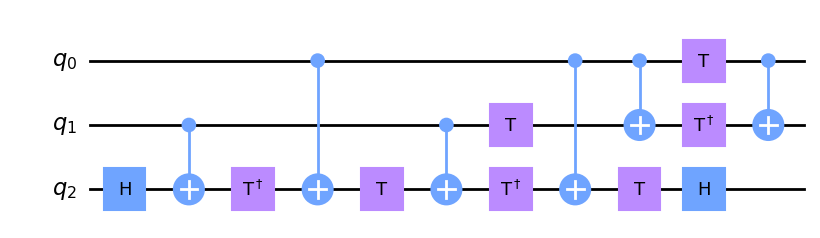

In [112]:
# # build a toffoli
# qc = QuantumCircuit(8)
# qc.ccx(0, 1, 2)
# qc.cx(1, 7)
# qc.ccx(3, 4, 5)
# qc.ccx(2, 5, 6)
# # build a 2x2 square coupling map
# coupling = CouplingMap.from_line(8)

# # build a toffoli
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
linear = CouplingMap.from_line(3)
a2a = CouplingMap.from_full(3)
coupling = linear
qc.decompose().draw("mpl")

In [113]:
# # generate network of random cnots
# n, M = 3, 10
# N = n**2
# qc = QuantumCircuit(N)

# for _ in range(M):
#     qc.cx(*np.random.choice(N, 2, replace=False))

# # coupling = CouplingMap.from_grid(n,n)
# coupling = CouplingMap.from_line(N)
# a2a = CouplingMap.from_full(N)
# qc.decompose().draw("mpl")

In [114]:
from qiskit import transpile

qc2 = transpile(
    qc, coupling_map=coupling, basis_gates=["cx", "u3"], optimization_level=3
)
t0_pm = PassManager([RootiSwapWeylDecomposition()])
qc3 = t0_pm.run(qc2)

print(f"Total: {qc3.count_ops()['riswap']}")
print(
    f"Depth: {qc3.depth(filter_function=lambda x: x.operation.name not in ['u3', 'u'])}"
)

# qc3.draw(output="mpl", fold=-1)

Total: 14
Depth: 14


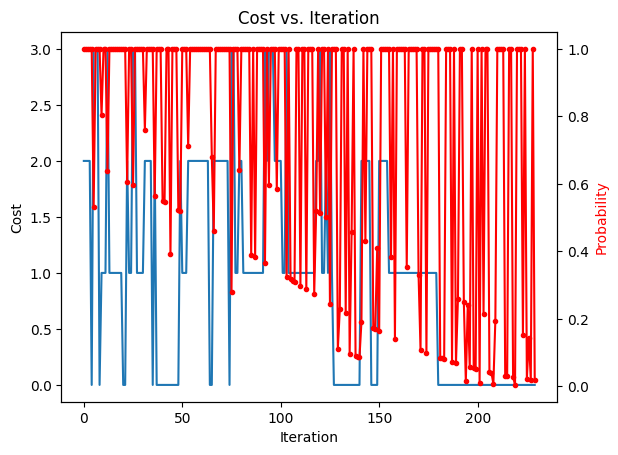

Total: 11
Depth: 11


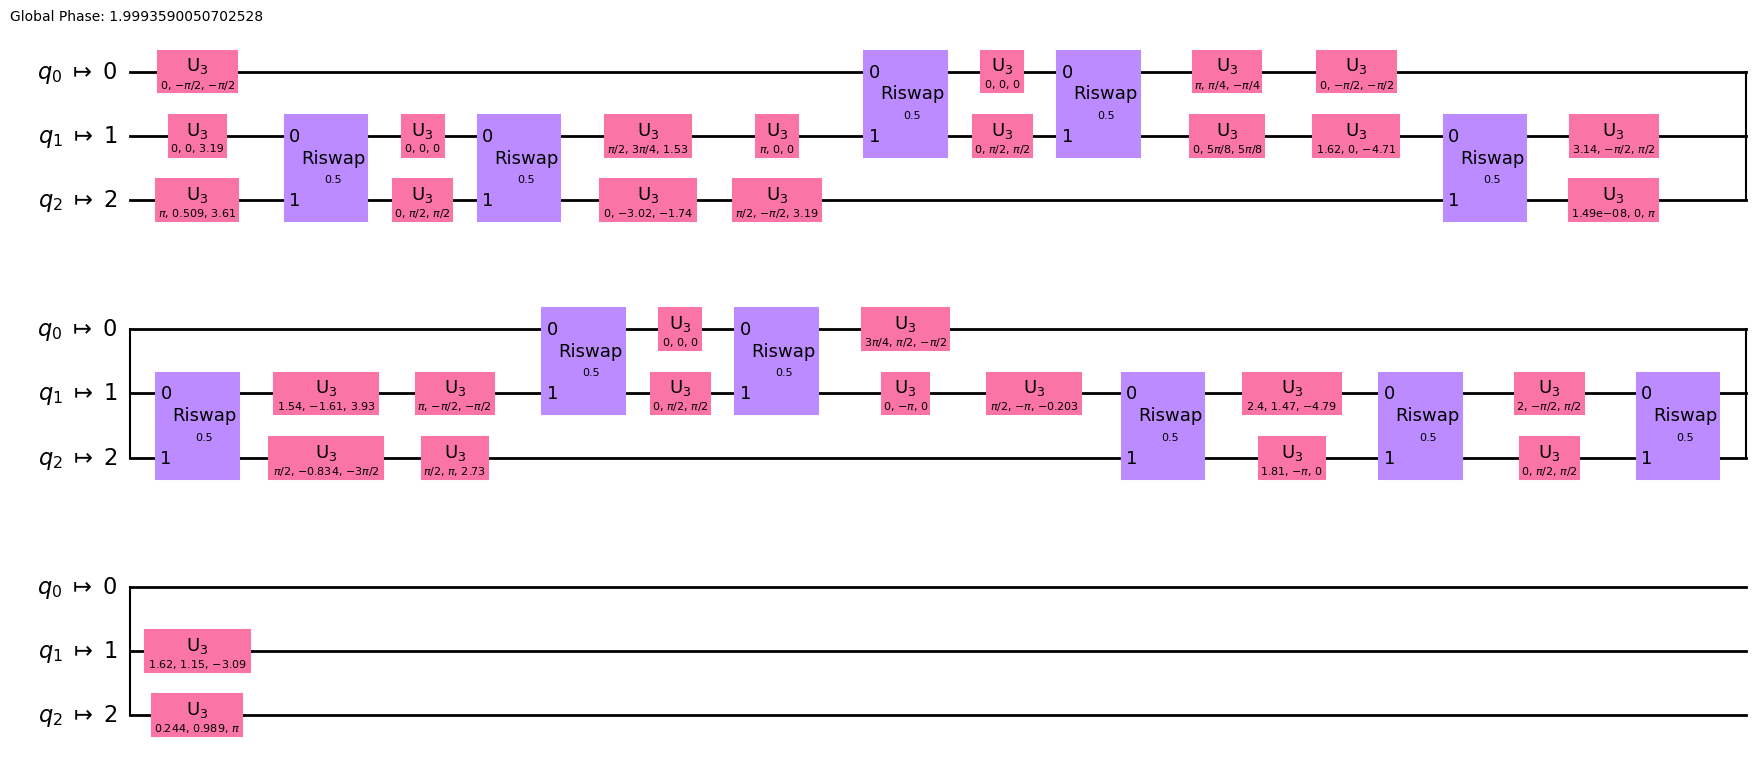

In [124]:
# run the pass
pm = PassManager()
pm.append([TrivialLayout(coupling)])
pm.append([FullAncillaAllocation(coupling), EnlargeWithAncilla(), ApplyLayout()])
pm.append(VirtualSwap(coupling, visualize=True))
pm.append(SabreSwap(coupling))
pm.append([OptimizeSwapBeforeMeasure()])
pm.append(
    [Collect1qRuns(), Collect2qBlocks(), ConsolidateBlocks(force_consolidate=True)]
)
pm.append([RootiSwapWeylDecomposition()])
new_circ = pm.run(qc)

print(f"Total: {new_circ.count_ops()['riswap']}")
print(
    f"Depth: {new_circ.depth(filter_function=lambda x: x.operation.name not in ['u3', 'u'])}"
)
new_circ.draw("mpl")

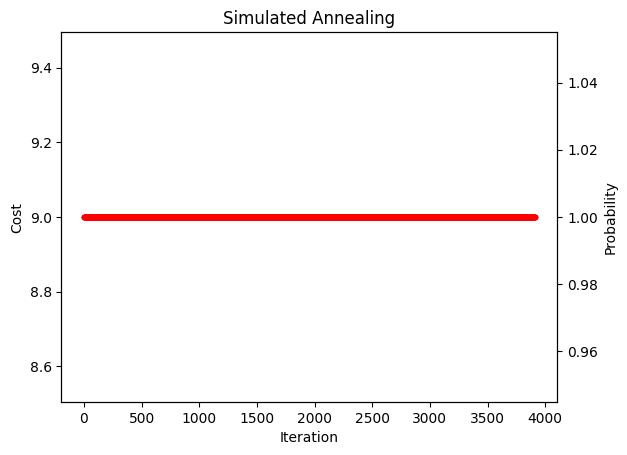

                                                                  »
q_0: ───────────────────────────────────────■─────────────────────»
                                          ┌─┴─┐┌────────────┐┌───┐»
q_1: ────────────────■──────────────────X─┤ X ├┤ U(0,0,π/4) ├┤ X ├»
     ┌────────────┐┌─┴─┐┌─────────────┐ │ └───┘└────────────┘└─┬─┘»
q_2: ┤ U(π/2,0,π) ├┤ X ├┤ U(0,0,-π/4) ├─X──────────────────────■──»
     └────────────┘└───┘└─────────────┘                           »
«                                                    ┌────────────┐     
«q_0: ─────────────────■─────────────────────────■───┤ U(0,0,π/4) ├──■──
«     ┌─────────────┐┌─┴─┐┌────────────────┐   ┌─┴─┐┌┴────────────┤┌─┴─┐
«q_1: ┤ U(0,0,-π/4) ├┤ X ├┤ U(π/2,0,-3π/4) ├─X─┤ X ├┤ U(0,0,-π/4) ├┤ X ├
«     └┬────────────┤└───┘└────────────────┘ │ └───┘└─────────────┘└───┘
«q_2: ─┤ U(0,0,π/4) ├────────────────────────X──────────────────────────
«      └────────────┘                                                   
Total: 13
Dep

In [7]:
seed = None
prep_qc = transpile(
    qc, basis_gates=["u", "iswap", "cx"], optimization_level=3, seed_transpiler=seed
)

# import logging
# logger = logging.getLogger('VSWAP')
# logger.setLevel(logging.INFO)

# run the pass
pm = PassManager()
pm.append([Unroller(["u", "iswap", "cx"]), TrivialLayout(coupling)])
pm.append([FullAncillaAllocation(coupling), EnlargeWithAncilla(), ApplyLayout()])
pm.append(VirtualSwap(coupling, visualize=True, seed=seed))
new_circ = pm.run(prep_qc)

print(f"Total: {new_circ.count_ops()['riswap']}")
print(
    f"Depth: {new_circ.depth(filter_function=lambda x: x.operation.name not in ['u3', 'u'])}"
)

In [ ]:
new_circ.draw(output="mpl", fold=-1)

In [ ]:
from transpile_benchy.main import Benchmark
from qiskit.transpiler.passes import RemoveBarriers, RemoveFinalMeasurements
from qiskit.transpiler.passes.layout import DenseLayout


# define some function that takes a circuit and returns a transpiled circuit
def t0(qc):
    cc = transpile(
        qc, coupling_map=coupling, basis_gates=["cx", "u3"], optimization_level=3
    )
    t0_pm = PassManager([RootiSwapWeylDecomposition()])
    return t0_pm.run(cc)


def t1(qc):
    prep_qc = transpile(
        qc,
        basis_gates=["u", "iswap", "cx"],
        coupling_map=coupling,
        optimization_level=3,
    )

    # run the pass
    pm = PassManager()
    pm.append([Unroller(["u", "iswap", "cx"]), TrivialLayout(coupling)])
    pm.append([FullAncillaAllocation(coupling), EnlargeWithAncilla(), ApplyLayout()])
    pm.append(VirtualSwap(coupling, visualize=True))
    return pm.run(prep_qc)


# def t2(c):
#     # qc_t0 = transpile(c, coupling_map=coupling, basis_gates=["cx", "u3"], optimization_level=3)
#     prep_qc = transpile(
#         c, basis_gates=["u", "cx", "iswap"], coupling_map=coupling, optimization_level=3
#     )
#     # layout = Layout(qc_t0._layout.input_qubit_mapping)
#     pm = PassManager()
#     pm.append([RemoveBarriers(), RemoveFinalMeasurements()])
#     pm.append([Unroller(["u", "iswap", "cx"]), DenseLayout(coupling)])
#     pm.append([FullAncillaAllocation(coupling), EnlargeWithAncilla(), ApplyLayout()])
#     pm.append(VirtualSwap(coupling, visualize=True))
#     pm.append(OptimizeSwapBeforeMeasure())
#     return pm.run(prep_qc)


b = Benchmark(t0, t1, size="small", prepath="../../../../transpile_benchy")
b.run()

# plot and save as svg
b.plot(save=True)

In [ ]:
b.depth_list